# Closure Modeling with Score Based FNO

In [15]:
import sys
sys.path.append('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation')

import time
import numpy as np
import h5py
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import warnings
warnings.filterwarnings("ignore")
from torch.optim import Adam
from functools import partial
from tqdm import trange
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Data_Generation.generator_sns import navier_stokes_2d_model
from utility import (set_seed, get_sigmas_karras, sampler)
from Model_Designs import (marginal_prob_std, diffusion_coeff, FNO2d_Interp, FNO2d_Conv)

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device('cuda')
else:
    print("CUDA is not available.")
    device = torch.device('cpu')


CUDA is available.


In [2]:
sigma = 26
marginal_prob_std_fn = partial(marginal_prob_std, sigma=sigma, device_=device)
diffusion_coeff_fn = partial(diffusion_coeff, sigma=sigma, device_=device)

modes = 8
width = 20

model_interp = FNO2d_Interp(marginal_prob_std_fn, modes, modes, width).cuda()
model_interp.load_state_dict(torch.load('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation'
                  '\\Trained_Models\\SparseDiffusionModelMidV_3040_interp.pth', map_location=device))

model_conv = FNO2d_Conv(marginal_prob_std_fn, modes, modes, width).cuda()
model_conv.load_state_dict(torch.load('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation'
                  '\\Trained_Models\\SparseDiffusionModelMidV_3040_conv.pth', map_location=device))

<All keys matched successfully>

In [3]:
filename = 'C:\\UWMadisonResearch\\Conditional_Score_FNO\\Data_Generation\\2d_ns_diffusion_50s_sto_midV.h5'

# Open the HDF5 file
with h5py.File(filename, 'r') as file:
    # Load data directly into PyTorch tensors on the specified device
    sol_t = torch.tensor(file['t'][()], device='cuda')
    sol = torch.tensor(file['sol'][()], device='cuda')
    diffusion = torch.tensor(file['diffusion'][()], device='cuda')
    nonlinear = torch.tensor(file['nonlinear'][()], device='cuda')

In [4]:
delta_t = 1e-3
nu = 1e-3
shifter = 30000
sample_size = 1
sample_steps = 10
total_steps = 20000
spatial_dim = 64

vorticity_init = sol[7:7+sample_size, :, :, shifter]

vorticity_condition = sol[7:7+sample_size, :, :, shifter: shifter+total_steps]

t = torch.linspace(0, 1, spatial_dim + 1, device=device)
t = t[0:-1]

X, Y = torch.meshgrid(t, t)
f = 0.1 * (torch.sin(2 * math.pi * (X + Y)) + torch.cos(2 * math.pi * (X + Y)))

In [5]:
# Extract sparse information for convoluted model
diffusion_target = diffusion[7:7+sample_size, :, :, shifter: shifter+total_steps]
# Define the size of the convolutional kernel
kernel_size = 7
kernel64 = torch.ones(1, 1, kernel_size, kernel_size) / kernel_size ** 2
kernel64 = kernel64.to(device)


mask = torch.zeros_like(diffusion_target)
mask[:, ::4, ::4, :] = 1
diffusion_target_sparse = diffusion_target * mask
diffusion_target_sparse_GF = torch.empty_like(diffusion_target_sparse)

for t in range(total_steps):
    slice_squeezed = diffusion_target_sparse[:, :, :, t].unsqueeze(1)
    slice_convolved  = F.conv2d(slice_squeezed, kernel64, padding='same')
    diffusion_target_sparse_GF[:, :, :, t] = slice_convolved.squeeze(1)

diffusion_target_sparse_normalized = torch.empty_like(diffusion_target_sparse_GF)
for i in range(diffusion_target_sparse_GF.shape[0]):
    for t in range(diffusion_target_sparse_GF.shape[3]):
        batch_sparse = diffusion_target_sparse[i, :, :, t][diffusion_target_sparse[i, :, :, t] != 0]
        batch_smoothed = diffusion_target_sparse_GF[i, :, :, t][diffusion_target_sparse_GF[i, :, :, t] != 0]
        sparse_min, sparse_max = torch.min(batch_sparse), torch.max(batch_sparse)
        smoothed_min, smoothed_max = torch.min(batch_smoothed), torch.max(batch_smoothed)
        batch_normalized = (diffusion_target_sparse_GF[i, :, :, t] - smoothed_min) / (smoothed_max - smoothed_min)
        batch_normalized = batch_normalized * (sparse_max - sparse_min) + sparse_min
        diffusion_target_sparse_normalized[i, :, :, t] = batch_normalized

In [6]:
vorticity_withG = torch.zeros(sample_size, spatial_dim, spatial_dim, total_steps)
vorticity_withoutG = torch.zeros(sample_size, spatial_dim, spatial_dim, total_steps)

In [16]:
sde_time_data: float = 0.5
sde_time_min = 1e-3
sde_time_max = 0.1

time_noises = get_sigmas_karras(sample_steps, sde_time_min, sde_time_max, device=device)

sampler_conv = partial(sampler,
                  score_model = model_conv,
                    spatial_dim = spatial_dim,
                    marginal_prob_std = marginal_prob_std_fn,
                    diffusion_coeff = diffusion_coeff_fn,
                    batch_size = sample_size,
                    num_steps = sample_steps,
                    time_noises = time_noises,
                    device = device)

In [19]:
vorticity_withoutG, _, t_withoutG = navier_stokes_2d_model(vorticity_init, f, nu, diffusion_target_sparse_normalized,
                                            sampler, closure = False, delta_t = delta_t,
                                            record_steps = total_steps, eval_steps=5)

In [17]:
vorticity_withG, _, t_withG = navier_stokes_2d_model(vorticity_init, f, nu, diffusion_target_sparse_normalized,
                                            sampler = sampler_conv, closure = True, delta_t = delta_t,
                                            record_steps = total_steps, eval_steps=5)

In [11]:
vorticity_withoutG.shape

torch.Size([1, 64, 64, 20000])

Time: 30.00s
RMSE: 0.0000
MSE: 0.00000000
RMSE NoG: 0.0000
MSE NoG: 0.0000
Time: 35.00s
RMSE: 0.0111
MSE: 0.00012261
RMSE NoG: 0.2431
MSE NoG: 0.0592
Time: 40.00s
RMSE: 0.0391
MSE: 0.00138437
RMSE NoG: 0.5771
MSE NoG: 0.3014
Time: 45.00s
RMSE: 0.0631
MSE: 0.00335225
RMSE NoG: 0.9246
MSE NoG: 0.7189
Time: 50.00s
RMSE: 0.0626
MSE: 0.00316394
RMSE NoG: 1.0315
MSE NoG: 0.8581


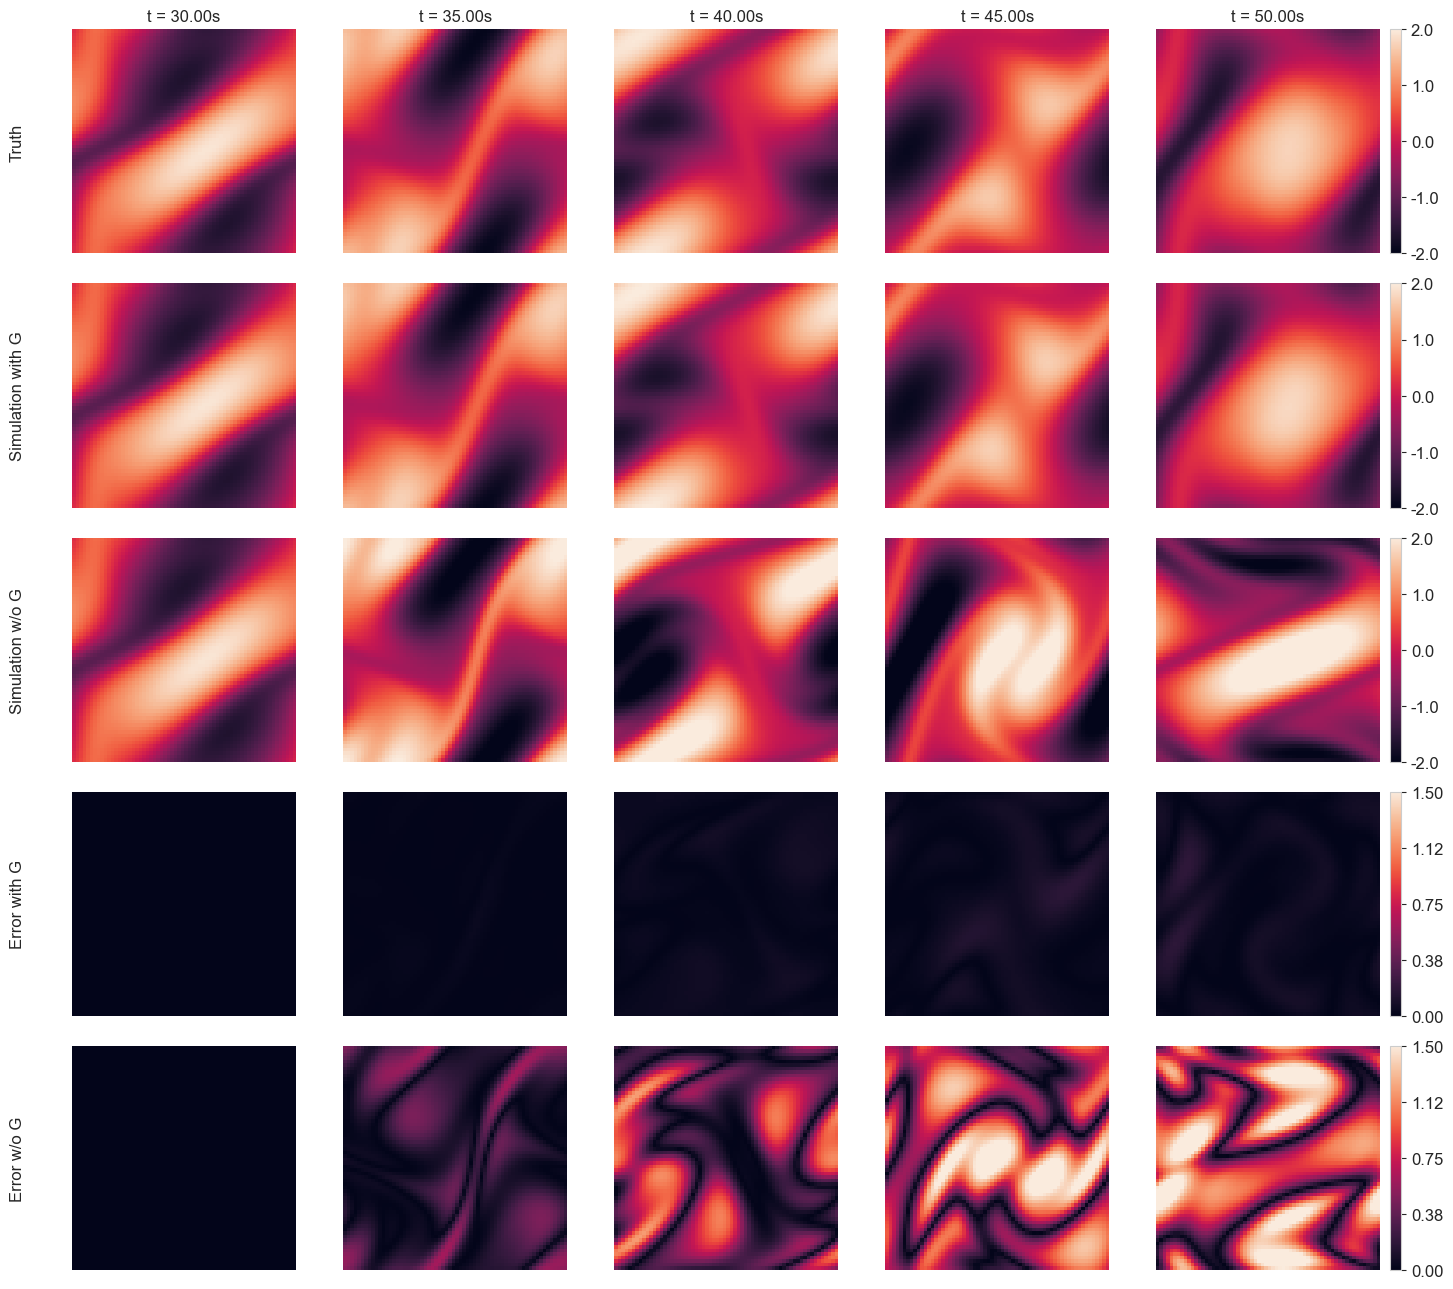

In [26]:
def relative_mse(tensor1, tensor2):
    """Calculate the Relative Mean Squared Error between two tensors."""
    rel_mse = torch.mean(torch.norm(tensor1 - tensor2, 2, dim=(0, 1)) / torch.norm(tensor2, 2, dim=(0, 1)))
    return rel_mse

def cal_mse(tensor1, tensor2):
    """Calculate the Mean Squared Error between two tensors."""
    mse = torch.mean((tensor1 - tensor2)**2)
    return mse

# Assuming 'vorticity_series', 'vorticity_NoG', and 'sol' are preloaded tensors
shifter = 30000
k = 0
fs = 12
# Create a figure and a grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 13), gridspec_kw={'width_ratios': [1]*4 + [1.073]})

# Plot each row using seaborn heatmap
for row in range(5):
    for i in range(5):  # Loop through all ten columns
        ax = axs[row, i]

        j = i * 4999
        generated = vorticity_withG[k, :, :, j].cpu()
        generated_nog = vorticity_withoutG[k, :, :, j].cpu()
        truth = sol[k + 7, :, :, shifter + j].cpu()
        error_field = abs(generated - truth)
        error_field_nog = abs(generated_nog - truth)

        rmse = relative_mse(torch.tensor(generated), torch.tensor(truth)).item()
        mse = cal_mse(torch.tensor(generated), torch.tensor(truth)).item()
        rmse_nog = relative_mse(torch.tensor(generated_nog), torch.tensor(truth)).item()
        mse_nog = cal_mse(torch.tensor(generated_nog), torch.tensor(truth)).item()

        if row == 0:
            print(f"Time: {sol_t[shifter + j]:.2f}s")
            print(f"RMSE: {rmse:.4f}")
            print(f"MSE: {mse:.8f}")
            print(f"RMSE NoG: {rmse_nog:.4f}")
            print(f"MSE NoG: {mse_nog:.4f}")

        # Set individual vmin and vmax based on the row
        if row == 0:
            data = truth
            vmin, vmax = -2.0, 2.0  # Limits for Truth and Generated rows
            ax.set_title(f't = {sol_t[shifter + j]:.2f}s', fontsize=fs)
        elif row == 1:
            data = generated
            vmin, vmax = -2.0, 2.0  # Limits for Truth and Generated rows
        elif row == 2:
            data = generated_nog
            vmin, vmax = -2.0, 2.0
        elif row == 3:
            data = error_field
            vmin, vmax = 0, 1.5
        else:
            data = error_field_nog
            vmin, vmax = 0, 1.5
        # Plot heatmap
        sns.heatmap(data, ax=ax, cmap="rocket", vmin=vmin, vmax=vmax, square=True, cbar=False)

        ax.axis('off')  # Turn off axis for cleaner look

        if i == 4:
            # Create a new axis for the colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cb = plt.colorbar(ax.collections[0], cax=cax, ticks=np.linspace(vmin, vmax, 5))
            cax.tick_params(labelsize=fs)

            # Format tick labels based on the row
            if row < 3:  # For the first two rows
                cb.ax.set_yticklabels(['{:.1f}'.format(tick) for tick in np.linspace(vmin, vmax, 5)])
            else:  # For the last row
                cb.ax.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(vmin, vmax, 5)])

# Add row titles on the side
row_titles = ['Truth', 'Simulation with G', 'Simulation w/o G', 'Error with G', 'Error w/o G']
for ax, row_title in zip(axs[:, 0], row_titles):
    ax.annotate(row_title, xy=(0.1, 0.5), xytext=(-50, 0),
                xycoords='axes fraction', textcoords='offset points',
                ha='right', va='center', rotation=90, fontsize=fs)

plt.tight_layout()  # Adjust the subplots to fit into the figure area
plt.show()

In [ ]:


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation


fig = plt.figure(figsize=(40, 30))  # Increased height slightly
wid = 0.26
hei = 0.35  # Reduced height slightly to make room for title and metrics
gap = 0.01  # Gap between plots

# Define the positions for each subplot [left, bottom, width, height]
ax1_pos = [0.02, 0.32, wid, hei]  # Truth (centered vertically)
ax2_pos = [0.35, 0.52, wid, hei]  # Generated with G (top right)
ax3_pos = [0.35, 0.1, wid, hei]  # Generated w/o G (bottom right)
ax4_pos = [0.68, 0.52, wid, hei]  # Error with G (top far right)
ax5_pos = [0.68, 0.1, wid, hei]  # Error w/o G (bottom far right)

# Create the subplots with the defined positions
ax1 = fig.add_axes(ax1_pos)
ax2 = fig.add_axes(ax2_pos)
ax3 = fig.add_axes(ax3_pos)
ax4 = fig.add_axes(ax4_pos)
ax5 = fig.add_axes(ax5_pos)

import seaborn as sns
import numpy as np

# Ticks setting
ticks_64 = np.arange(0, 64, 10 * 64 / 64)
ticks_64_y = np.arange(4, 65, 10 * 64 / 64)[::-1]
tick_labels_64 = [str(int(tick)) for tick in ticks_64]

def animate(t):
    global sol, vorticity_series, vorticity_NoG, sol_t
    fs = 30
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.cla()

    if hasattr(animate, 'colorbar_axes'):
        for cax in animate.colorbar_axes:
            cax.remove()

    if hasattr(animate, 'txt'):
        for txt in animate.txt:
            txt.remove()

    frame_index = min(10 * t, 19999)

    # Define color limits
    vorticity_limits = [-2.0, 2.0]
    error_limits = [0.00, 1.50]

    # Plot for sol tensor (Truth)
    sns.heatmap(sol[k + 7, ..., shifter + 10 * t].cpu().detach(), ax=ax1, cmap='rocket',
                cbar_ax=fig.add_axes([ax1_pos[0] + ax1_pos[2] + gap, ax1_pos[1], 0.01, ax1_pos[3]]),
                vmin=vorticity_limits[0], vmax=vorticity_limits[-1])
    ax1.set_title("Truth", fontsize=fs)
    ax1.collections[0].colorbar.set_ticks(np.linspace(vorticity_limits[0], vorticity_limits[-1], 5))
    ax1.collections[0].colorbar.ax.tick_params(labelsize=fs)

    # Plot for vorticity_series tensor (Generated with G)
    sns.heatmap(vorticity_series[k, ..., frame_index].cpu().detach(), ax=ax2, cmap='rocket',
                cbar_ax=fig.add_axes([ax2_pos[0] + ax2_pos[2] + gap, ax2_pos[1], 0.01, ax2_pos[3]]),
                vmin=vorticity_limits[0], vmax=vorticity_limits[-1])
    ax2.set_title("Generated with G", fontsize=fs)
    ax2.collections[0].colorbar.set_ticks(np.linspace(vorticity_limits[0], vorticity_limits[-1], 5))
    ax2.collections[0].colorbar.ax.tick_params(labelsize=fs)

    # Plot for vorticity_NoG tensor (Generated w/o G)
    sns.heatmap(vorticity_NoG[k, ..., frame_index].cpu().detach(), ax=ax3, cmap='rocket',
                cbar_ax=fig.add_axes([ax3_pos[0] + ax3_pos[2] + gap, ax3_pos[1], 0.01, ax3_pos[3]]),
                vmin=vorticity_limits[0], vmax=vorticity_limits[-1])
    ax3.set_title("Generated w/o G", fontsize=fs)
    ax3.collections[0].colorbar.set_ticks(np.linspace(vorticity_limits[0], vorticity_limits[-1], 5))
    ax3.collections[0].colorbar.ax.tick_params(labelsize=fs)

    # Calculate and plot the absolute error with G
    abs_error_2 = torch.abs(sol[k + 7, ..., shifter + 10 * t].cpu() - vorticity_series[k, ..., frame_index].cpu())
    sns.heatmap(abs_error_2, ax=ax4, cmap='rocket',
                cbar_ax=fig.add_axes([ax4_pos[0] + ax4_pos[2] + gap, ax4_pos[1], 0.01, ax4_pos[3]]),
                vmin=error_limits[0], vmax=error_limits[-1])
    ax4.set_title("Error with G", fontsize=fs)
    ax4.collections[0].colorbar.set_ticks(np.linspace(error_limits[0], error_limits[-1], 5))
    ax4.collections[0].colorbar.ax.tick_params(labelsize=fs)

    # Calculate and plot the absolute error without G
    abs_error = torch.abs(sol[k + 7, ..., shifter + 10 * t].cpu() - vorticity_NoG[k, ..., frame_index].cpu())
    sns.heatmap(abs_error, ax=ax5, cmap='rocket',
                cbar_ax=fig.add_axes([ax5_pos[0] + ax5_pos[2] + gap, ax5_pos[1], 0.01, ax5_pos[3]]),
                vmin=error_limits[0], vmax=error_limits[-1])
    ax5.set_title("Error w/o G", fontsize=fs)
    ax5.collections[0].colorbar.set_ticks(np.linspace(error_limits[0], error_limits[-1], 5))
    ax5.collections[0].colorbar.ax.tick_params(labelsize=fs)

    animate.colorbar_axes = [ax1.collections[0].colorbar.ax, ax2.collections[0].colorbar.ax,
                             ax3.collections[0].colorbar.ax, ax4.collections[0].colorbar.ax,
                             ax5.collections[0].colorbar.ax]

    # Calculate metrics
    re_with_G = relative_mse(sol[k + 7, ..., shifter + 10 * t].cpu(), vorticity_series[k, ..., frame_index].cpu())
    re_without_G = relative_mse(sol[k + 7, ..., shifter + 10 * t].cpu(), vorticity_NoG[k, ..., frame_index].cpu())
    mse_with_G = cal_mse(sol[k + 7, ..., shifter + 10 * t].cpu(), vorticity_series[k, ..., frame_index].cpu())
    mse_without_G = cal_mse(sol[k + 7, ..., shifter + 10 * t].cpu(), vorticity_NoG[k, ..., frame_index].cpu())

    # Update figure title and captions with metrics
    fig.suptitle(r'$\nu = 10^{-3}, \beta = 0.00005, dt = 10^{-3}$' + '\n' + f't = {sol_t[shifter + 10 * t].item():.3f}',
                 fontsize=fs, y=0.95)

    txt1 = fig.text(0.65, 0.48,
                    f'MSE (with G): {mse_with_G.item():.4f}, RE (with G): {re_with_G.mean().item():.4f}',
                    ha='center', fontsize=fs)
    txt2 = fig.text(0.65, 0.06,
                    f'MSE (w/o G): {mse_without_G.item():.4f}, RE (w/o G): {re_without_G.mean().item():.4f}',
                    ha='center', fontsize=fs)

    animate.txt = [txt1, txt2]

    # Adjust x and y axis ticks
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xticks(ticks_64)
        ax.set_yticks(ticks_64_y)
        ax.tick_params(axis='both', which='major', labelsize=fs, rotation=0)
        ax.set_xticklabels(tick_labels_64, rotation=0, ha='center')
        ax.set_yticklabels(tick_labels_64, rotation=0, va='center')

    # Print progress
    progress = (t + 1) / 2000 * 100
    if t % 10 == 0:
        print(f"Progress: {progress:.2f}%")


# Create the animation
Animation1 = matplotlib.animation.FuncAnimation(fig, animate, frames=2000)
plt.close(fig)  # This prevents the static plot from displaying in Jupyter notebooks

# Save the animation
Animation1.save('Animation3050WithAndWithoutG.mp4', writer='ffmpeg', fps=60)